# Hierarchical Agent Teams

## 단일 슈퍼바이저 노드 아키텍쳐에서 발생할 수 있는 문제
- 단일 작업자에게 주어진 작업이 너무 복잡해지는 경우
    - 한 명의 작업자가 처리하기엔 너무 많은 작업이 포함될 수 있음
- 작업자의 수가 너무 많아지는 경우
    - 단일 슈퍼바이저가 모든 작업을 관리하기 어려워질 수 있음

## 해결책 
- 이러한 문제를 해결하려면 작업을 계층적으로 분배하는 것이 더 효과적일 수 있음 
- 여러 개의 서브그래프를 조합하여, 최상위 슈퍼바이저와 중간 슈퍼바이저를 생성
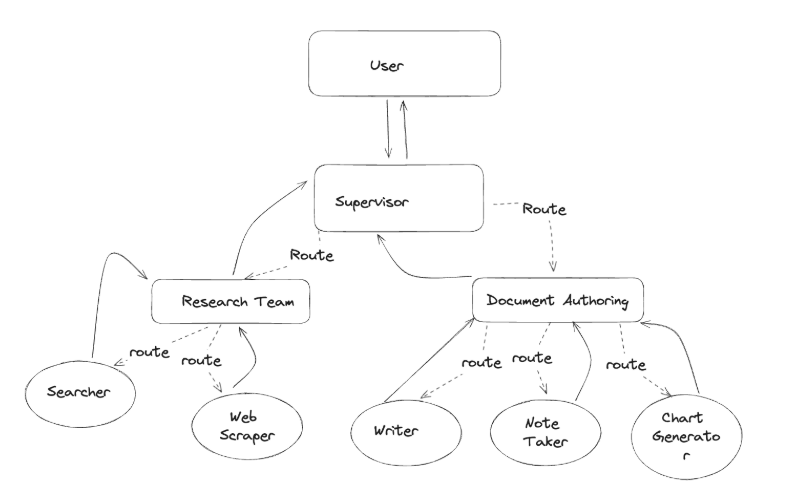

# 랭스미스 

In [2]:
import os
import getpass
import os

from dotenv import load_dotenv

from langsmith import utils 

import operator
from langchain_groq import ChatGroq


# 환경 변수 로드
load_dotenv()

utils.tracing_is_enabled()

True

## LLM선언

In [7]:
llm = ChatGroq( # model="mixtral-8x7b-32768",
    model="gemma2-9b-it",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

### ResearchTeam Tool

In [1]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
tavily_tool = TavilySearchResults(max_results=5)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### Document Writing Team Tool

In [9]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict


In [10]:
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

In [11]:
# 주요 포인트를 기반으로 개요(outline)를 생성하는 도구
# 목차 파일 생성하는 도구 
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 파일 내용 읽고 특정 줄만 선택적으로 반환할 수 있는 도구 
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

# 문서 작성 도구 
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


In [12]:
# 
repl = PythonREPL()

# 입력된 파이썬 코드 실행 및 결과 반환 
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

## 보조 유틸리티 함수
- 2가지 작업 간결화
    1. 워커 에이저늩 생성
    2. 서브 그래프의 슈퍼바이저 생성



In [13]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

In [14]:
class State(MessagesState):
    next: str

"""
"당신은 다음 작업자들 간의 대화를 관리하는 임무를 맡은 감독자(Supervisor)입니다: {members}.
주어진 사용자 요청(user request)을 바탕으로, 다음 작업을 수행할 작업자(worker)를 선택하여 응답하세요.

각 작업자는 하나의 작업(task)을 수행한 후, 결과(results)와 상태(status)를 반환합니다.
모든 작업이 완료되면 "FINISH"라고 응답하세요."**
"""
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options =["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]
        
    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

# Agent 팀 정의

## 1.research Team

In [15]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [16]:
search_agent = create_react_agent(llm, tools=[tavily_tool])

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


# 스크래퍼 감독
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])


In [18]:
# 워크플로우 빌드 
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

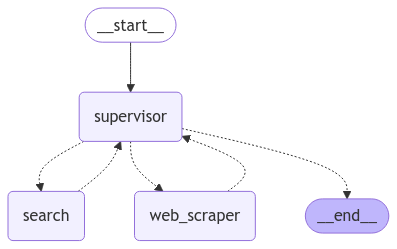

In [19]:
# 시각화
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [21]:
# 실행
for s in research_graph.stream(
    {"messages": [("user", "가장 빠른 CPI 발표날짜는 언제냐?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='2024년 2월 13일', additional_kwargs={}, response_metadata={}, name='search', id='8fcd49cc-728f-4ead-a4a9-10cc5c7a16eb')]}}
---
{'supervisor': {'next': '__end__'}}
---


## Document Writing Team

In [23]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)

def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)

def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [24]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

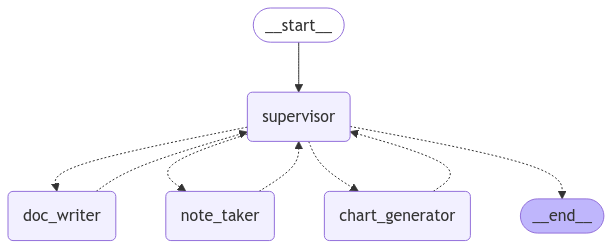

In [25]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [26]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "write_document"\n\t\t},\n\t\t"parameters": {\n\t\t\t"content": "## Poem Outline: Cats\n\n**Stanza 1:**\n* Fluffy fur, soft paws\n* Eyes that gleam in the night\n* A playful pounce, a gentle purr\n\n**Stanza 2:**\n* Independent spirit, a curious soul\n* Hunter by nature, a graceful stride\n* A silent shadow, a watchful gaze\n\n**Stanza 3:**\n* A loyal companion, a furry friend\n* Warmth and comfort, a love that knows no end\n* A purrfect poem, a tribute to our feline kin",\n\t\t\t"file_name": "cat_poem.txt"\n\t\t}\n\t}\n}\n</tool-use> \n'}}